*ref: https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_train_test.html*

In [1]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing(as_frame=True)
data, target = housing.data, housing.target

In this dataset, the aim is to predict the median value of houses in an area in California. The features collected are based on general real-estate and geographical information.

In [2]:
print(housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

In [5]:
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [6]:
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

In [4]:
# To simplify future visualization, let’s transform the prices from the 100 (k$) range to the thousand dollars (k$) range.

target *= 100
target.head()

0    452.6
1    358.5
2    352.1
3    341.3
4    342.2
Name: MedHouseVal, dtype: float64

# Training error vs testing error

In [7]:
# To solve this regression task, we will use a decision tree regressor.

from sklearn.tree import DecisionTreeRegressor

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(data, target)

DecisionTreeRegressor(random_state=0)

In [8]:
# After training the regressor, we would like to know its potential generalization 
# performance once deployed in production. 
# For this purpose, we use the mean absolute error, 
# which gives us an error in the native unit, i.e. k$.

from sklearn.metrics import mean_absolute_error

target_predicted = regressor.predict(data)
score = mean_absolute_error(target, target_predicted)
print(f"On average, our regressor makes an error of {score:.2f} k$")

On average, our regressor makes an error of 0.00 k$


We get perfect prediction with no error. It is too optimistic and almost always revealing a methodological problem when doing machine learning.

Indeed, we trained and predicted on the same dataset. Since our decision tree was fully grown, every sample in the dataset is stored in a leaf node. Therefore, our decision tree fully memorized the dataset given during fit and therefore made no error when predicting.

This error computed above is called the **empirical error or training error.**

We trained a predictive model to minimize the training error but our aim is to minimize the error on data that has not been seen during training.

This error is also called the **generalization error or the “true” testing error.**

Thus, the most basic evaluation involves:
- splitting our dataset into two subsets: a training set and a testing set;
- fitting the model on the training set;
- estimating the training error on the training set;
- estimating the testing error on the testing set.

In [9]:
#So let’s split our dataset.

from sklearn.model_selection import train_test_split

data_train, data_test, target_train, target_test = train_test_split(
    data, target, random_state=0)

In [10]:
#Then, let’s train our model.

regressor.fit(data_train, target_train)

DecisionTreeRegressor(random_state=0)

In [13]:
# Finally, we estimate the different types of errors. 
# Let’s start by computing the training error.

target_predicted = regressor.predict(data_train)
score = mean_absolute_error(target_train, target_predicted)
print(f"The training error of our model is {score:.2f} k$")

The training error of our model is 0.00 k$


In [15]:
# we now compute the testing error.

target_predicted = regressor.predict(data_test)
score = mean_absolute_error(target_test, target_predicted)
print(f"The testing error of our model is {score:.2f} k$")

The testing error of our model is 47.28 k$


# Stability of the cross-validation estimates
**Cross-validation** allows estimating the **robustness of a predictive model** by repeating the splitting procedure. It will give several training and testing errors and thus some estimate of the variability of the model generalization performance.

There are different cross-validation strategies, for now we are going to focus on one called **“shuffle-split”**. At each iteration of this strategy we:
- randomly shuffle the order of the samples of a copy of the full dataset;
- split the shuffled dataset into a train and a test set;
- train a new model on the train set;
- evaluate the testing error on the test set.

We repeat this procedure n_splits times. Keep in mind that the computational cost increases with n_splits.

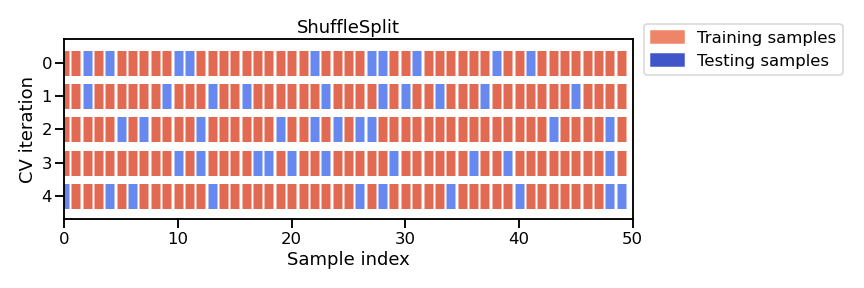

In this case we will set n_splits=40, meaning that we will train 40 models in total and all of them will be discarded: we just record their **generalization performance on each variant of the test set**.

In [17]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)
cv_results = cross_validate(
    regressor, data, target, cv=cv, scoring="neg_mean_absolute_error")

In [18]:
# The results cv_results are stored into a Python dictionary. 
# We will convert it into a pandas dataframe to ease visualization and manipulation.

import pandas as pd

cv_results = pd.DataFrame(cv_results)
cv_results.head()

,fit_time,score_time,test_score
0,0.317027,0.006003,-46.909797
1,0.315962,0.005999,-46.421170
2,0.309999,0.008001,-47.411089
3,0.325967,0.007039,-44.319824
4,0.314962,0.006000,-47.607875


In [19]:
#Let us revert the negation to get the actual error:
cv_results["test_error"] = -cv_results["test_score"]

#Let’s check the results reported by the cross-validation.
cv_results.head(10)

,fit_time,score_time,test_score,test_error
0,0.317027,0.006003,-46.909797,46.909797
1,0.315962,0.005999,-46.421170,46.421170
2,0.309999,0.008001,-47.411089,47.411089
3,0.325967,0.007039,-44.319824,44.319824
4,0.314962,0.006000,-47.607875,47.607875
5,0.317117,0.006172,-45.901300,45.901300
6,0.320028,0.007000,-46.572767,46.572767
7,0.294999,0.007004,-46.194585,46.194585
8,0.327005,0.007000,-45.590236,45.590236
9,0.322031,0.006001,-45.727998,45.727998


In [20]:
len(cv_results)

40

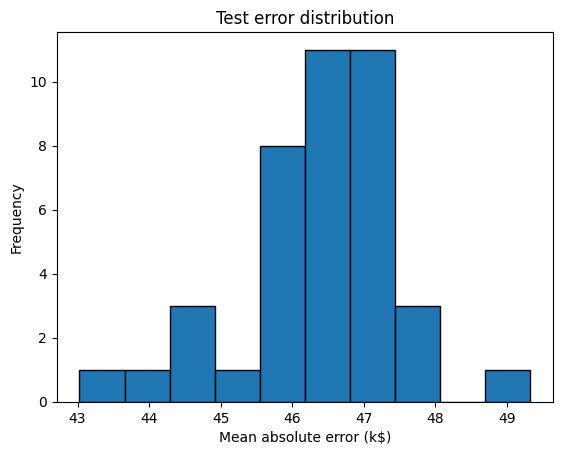

In [21]:
# We get 40 entries in our resulting dataframe because we performed 40 splits. 
# Therefore, we can show the testing error distribution and thus, have an estimate of its variability.

import matplotlib.pyplot as plt

cv_results["test_error"].plot.hist(bins=10, edgecolor="black")
plt.xlabel("Mean absolute error (k$)")
_ = plt.title("Test error distribution")

In [22]:
# We observe that the testing error is clustered around 47 k$ and ranges from 43 k$ to 50 k$.

print(f"The mean cross-validated testing error is: "
      f"{cv_results['test_error'].mean():.2f} k$")

The mean cross-validated testing error is: 46.36 k$


In [23]:
print(f"The standard deviation of the testing error is: "
      f"{cv_results['test_error'].std():.2f} k$")

The standard deviation of the testing error is: 1.17 k$


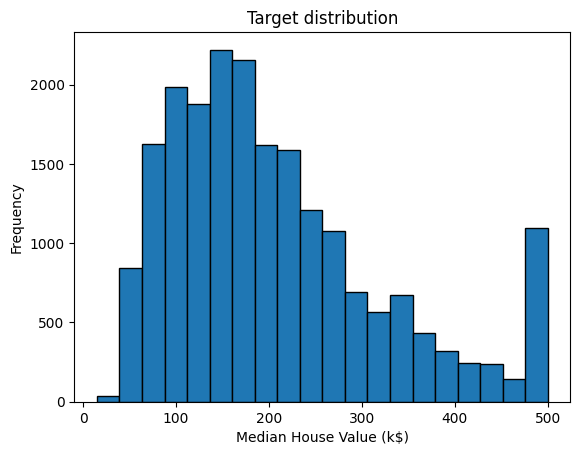

In [25]:
# Let us plot the distribution of the target variable:

target.plot.hist(bins=20, edgecolor="black")
plt.xlabel("Median House Value (k$)")
_ = plt.title("Target distribution")

In [26]:
print(f"The standard deviation of the target is: {target.std():.2f} k$")

The standard deviation of the target is: 115.40 k$


# More detail regarding cross_validate
During cross-validation, many models are trained and evaluated. Indeed, the number of elements in each array of the output of cross_validate is a result from one of these fit/score procedures. 

To make it explicit, it is possible to retrieve these fitted models for each of the splits/folds by passing the option return_estimator=True in cross_validate.

In [27]:
cv_results = cross_validate(regressor, data, target, return_estimator=True)
cv_results

{'fit_time': array([0.36199021, 0.36351204, 0.38107443, 0.39699697, 0.35900187]),
 'score_time': array([0.00500369, 0.00449347, 0.00699854, 0.00400114, 0.00500154]),
 'estimator': [DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0),
  DecisionTreeRegressor(random_state=0)],
 'test_score': array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])}

In [28]:
cv_results["estimator"]

[DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0),
 DecisionTreeRegressor(random_state=0)]

In [29]:
# In the case where you only are interested in the test score, 
# scikit-learn provide a cross_val_score function. 
# It is identical to calling the cross_validate function and to select the test_score only.

from sklearn.model_selection import cross_val_score

scores = cross_val_score(regressor, data, target)
scores

array([0.26291527, 0.41947109, 0.44492564, 0.23357874, 0.40788361])